In [3]:
import os
import random
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, GlobalAveragePooling2D, Input, Lambda
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import warnings
warnings.filterwarnings('ignore')


## Import data

In [4]:
train_dir = '/content/train'
test_dir = '/content/test'

### Train set

In [5]:
image_paths = []
labels = []

for class_name in os.listdir(train_dir):
    class_folder = os.path.join(train_dir, class_name)

    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_name)

train_set = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})


print(train_set.head())


                                   image_path  label
0  /content/train/angry/Training_86515936.jpg  angry
1  /content/train/angry/Training_38797120.jpg  angry
2  /content/train/angry/Training_93780674.jpg  angry
3   /content/train/angry/Training_8917656.jpg  angry
4  /content/train/angry/Training_71131403.jpg  angry


In [6]:
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [48, 48])
    image = image / 255.0
    label = tf.cast(label, tf.float32)
    return image, label

label_to_index = {label: idx for idx, label in enumerate(train_set['label'].unique())}
train_set['label_idx'] = train_set['label'].map(label_to_index)

train_dataset = tf.data.Dataset.from_tensor_slices((train_set['image_path'].values, train_set['label_idx'].values))
train_dataset = train_dataset.map(load_image).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print(f'image shape is: {images.shape}')
    print(labels)
    print(labels.shape)
    print(type(labels))
    print('--------------------------')


image shape is: (32, 48, 48, 1)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(32,), dtype=float32)
(32,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
--------------------------


### Test set

In [7]:
image_paths_1 = []
labels_1 = []

for class_name in os.listdir(test_dir):
    class_folder = os.path.join(test_dir, class_name)

    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            image_paths_1.append(os.path.join(class_folder, img_file))
            labels_1.append(class_name)

test_set = pd.DataFrame({
    'image_path': image_paths_1,
    'label': labels_1
})


print(test_set.head())


                                     image_path  label
0   /content/test/angry/PublicTest_15140838.jpg  angry
1  /content/test/angry/PrivateTest_29626348.jpg  angry
2   /content/test/angry/PublicTest_62277373.jpg  angry
3  /content/test/angry/PrivateTest_33746988.jpg  angry
4   /content/test/angry/PublicTest_43895652.jpg  angry


In [8]:
test_set['label_idx'] = test_set['label'].map(label_to_index)

test_dataset = tf.data.Dataset.from_tensor_slices((test_set['image_path'].values, test_set['label_idx'].values))
test_dataset = test_dataset.map(load_image).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

for images, labels in test_dataset.take(1):
    print(f'image shape is: {images.shape}')
    print(labels)
    print(labels.shape)


image shape is: (64, 48, 48, 1)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(64,), dtype=float32)
(64,)


## Data description

In [9]:
index_to_label = {value: key for key, value in label_to_index.items()}
print(label_to_index)

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'disgust': 4, 'sad': 5, 'surprise': 6}


In [10]:
labels_list = []

for images, labels in train_dataset:
    labels_list.extend(labels.numpy())

labels_tensor = tf.constant(labels_list)

unique_labels, idx= tf.unique(labels_tensor)

label_counts = tf.math.bincount(idx)

table = PrettyTable(['Index', 'Label', 'Count'])
for label, count in zip(unique_labels.numpy(), label_counts.numpy()):
    table.add_row([int(label), index_to_label[label], count])

print(table)

+-------+----------+-------+
| Index |  Label   | Count |
+-------+----------+-------+
|   0   |  angry   |  3995 |
|   1   |   fear   |  4097 |
|   2   |  happy   |  7215 |
|   3   | neutral  |  4965 |
|   4   | disgust  |  436  |
|   5   |   sad    |  4830 |
|   6   | surprise |  3171 |
+-------+----------+-------+


In [11]:
labels_list_1 = []

for images, labels in test_dataset:
    labels_list_1.extend(labels.numpy())

labels_tensor_1 = tf.constant(labels_list_1)

unique_labels_1, idx_1= tf.unique(labels_tensor_1)

label_counts_1 = tf.math.bincount(idx_1)

table = PrettyTable(['Index', 'Label', 'Count'])
for label, count in zip(unique_labels.numpy(), label_counts.numpy()):
    table.add_row([int(label), index_to_label[label], count])

print(table)

+-------+----------+-------+
| Index |  Label   | Count |
+-------+----------+-------+
|   0   |  angry   |  3995 |
|   1   |   fear   |  4097 |
|   2   |  happy   |  7215 |
|   3   | neutral  |  4965 |
|   4   | disgust  |  436  |
|   5   |   sad    |  4830 |
|   6   | surprise |  3171 |
+-------+----------+-------+


## Data Balancing

#### Description:
The goal was ensure that all sets at least have 3995 images. For sets with fewer than 3995 images, data augmentation techniques were applied to increase the number of images.


In [12]:
train_dataset = train_dataset.unbatch()

In [13]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def filter_by_label(label,target_label = 0):
    return tf.equal(label, target_label)

def extract_images(images, labels):
    return images


In [14]:
datasets = []

for lab in range(7):

    filtered = train_dataset.filter(lambda image, label: filter_by_label(label, target_label = lab))
    count = 0
    for _ in filtered:
        count += 1
    if count < 3996:

        filtered_imgs = filtered.map(extract_images)

        augmented_images = [img for img in filtered_imgs]
        num_augmented_images = 3996
        while len(augmented_images) < num_augmented_images:
            for image in filtered_imgs:
                augmented_images.append(augment_image(image).numpy())
                if len(augmented_images) >= num_augmented_images:
                    break

        augmented_labels = np.full((num_augmented_images,),lab, dtype=np.float32)

        generate_img = tf.data.Dataset.from_tensor_slices(augmented_images)
        generate_labl = tf.data.Dataset.from_tensor_slices(augmented_labels)

        augment = tf.data.Dataset.zip((generate_img, generate_labl))
        datasets.append(augment)
    else :
        selected = filtered.take(3995)
        datasets.append(selected)


final_train = datasets[0]
for dataset in datasets[1:]:
    final_train = final_train.concatenate(dataset)

In [15]:
labels_list = []

for images, labels in final_train:
    labels_list.extend([labels.numpy()])

labels_tensor = tf.constant(labels_list)

unique_labels, idx= tf.unique(labels_tensor)

label_counts = tf.math.bincount(idx)

table = PrettyTable(['Index', 'Label', 'Count'])
for label, count in zip(unique_labels.numpy(), label_counts.numpy()):
    table.add_row([int(label), index_to_label[label], count])

print(table)

+-------+----------+-------+
| Index |  Label   | Count |
+-------+----------+-------+
|   0   |  angry   |  3996 |
|   1   |   fear   |  3995 |
|   2   |  happy   |  3995 |
|   3   | neutral  |  3995 |
|   4   | disgust  |  3996 |
|   5   |   sad    |  3995 |
|   6   | surprise |  3996 |
+-------+----------+-------+


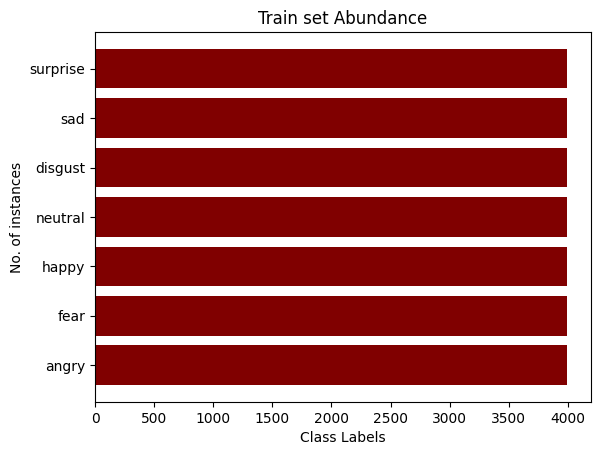

In [16]:
uniq_label = []
for label in label_to_index.keys():
    uniq_label.append(label)

plt.barh(uniq_label, label_counts.numpy(), color ='maroon',
        )

plt.xlabel("Class Labels")
plt.ylabel("No. of instances")
plt.title("Train set Abundance")
plt.show()

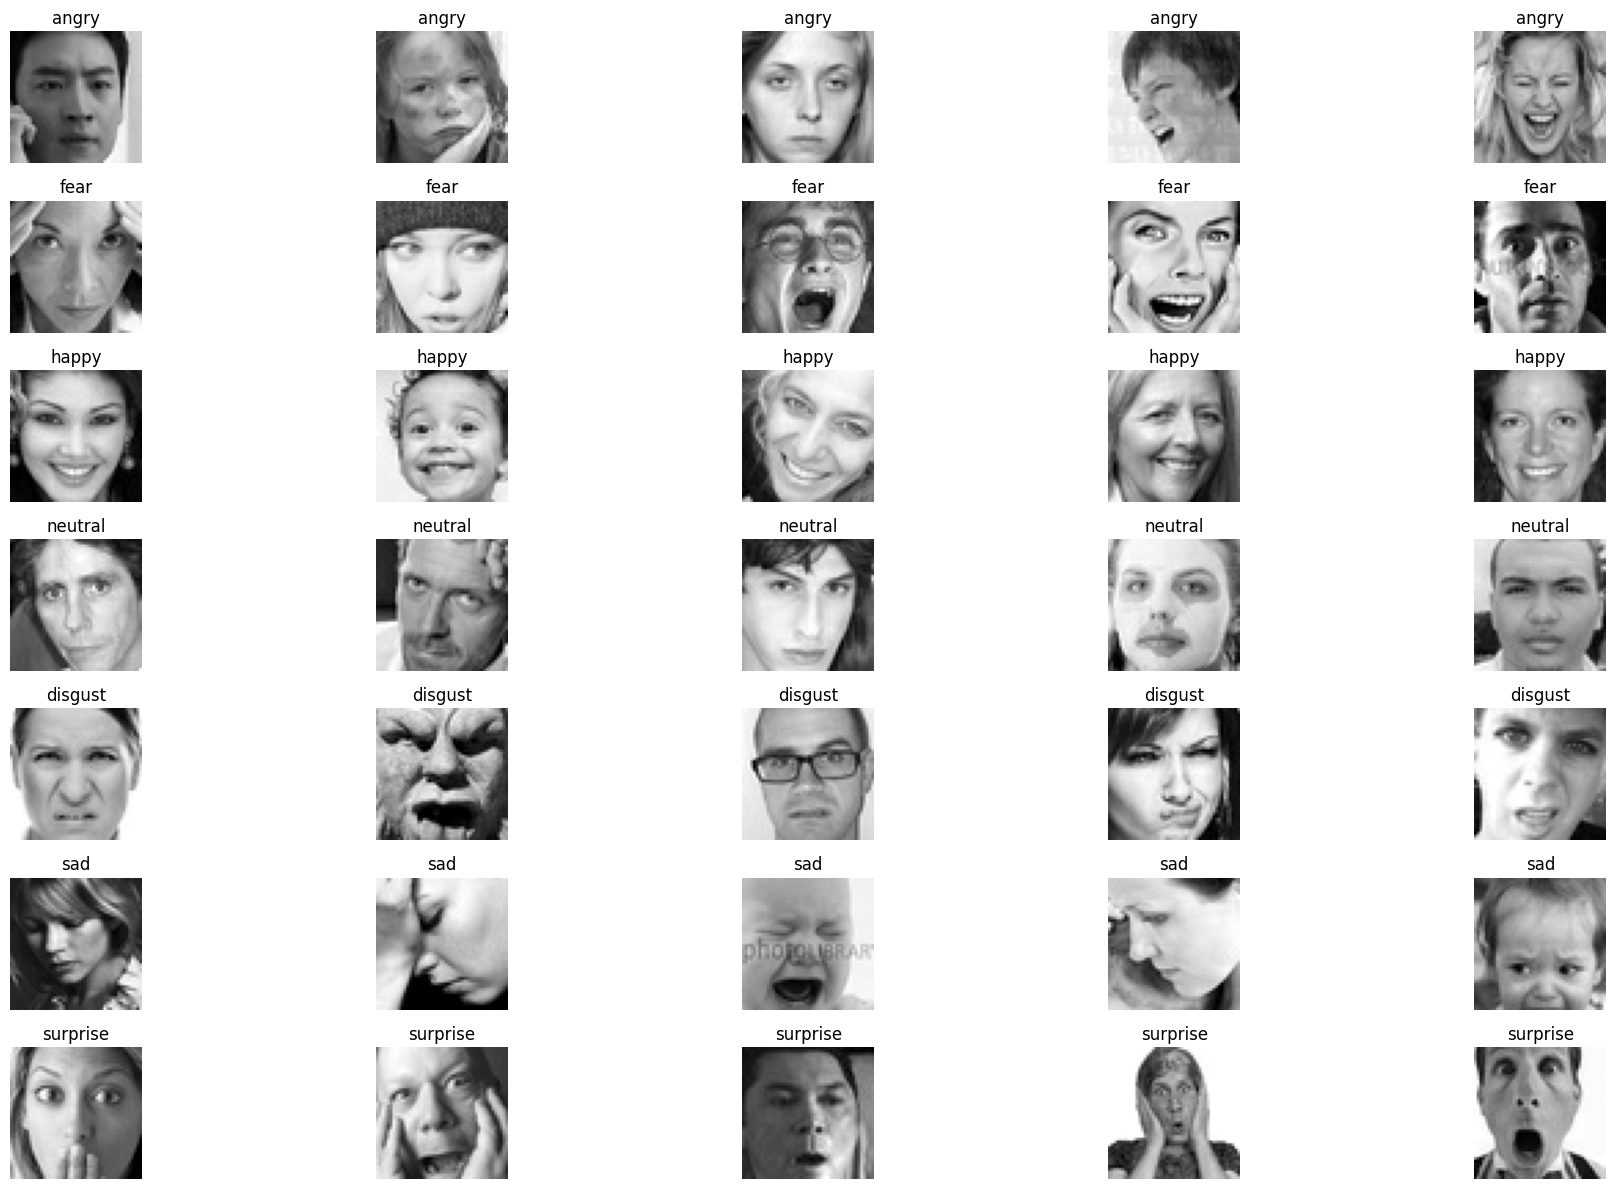

In [17]:
pic = []
labl = []
for lab in range(7):
    filtered = train_dataset.filter(lambda image, label: filter_by_label(label, target_label = lab))
    shuflled = filtered.shuffle(buffer_size= 3995, seed= 42)
    selected = shuflled.take(5)
    for img, label in selected:
        pic.append(img.numpy())
        labl.append(label.numpy())

fig, ax = plt.subplots(7, 5, figsize=(20, 12))
c = 0
for i in range(len(pic)):
    if i%5 == 0:
        c = 0
    label = labl[i]
    label_name = index_to_label[label]
    idx = int(label)
    single_image = pic[i]
    single_image = single_image.squeeze()
    ax[idx, c].imshow(single_image, cmap='gray')
    ax[idx, c].set_title(label_name)
    ax[idx, c].axis('off')
    c += 1

plt.tight_layout()
plt.show()

In [18]:
final_train = final_train.shuffle(buffer_size= 27968, seed= 42)
final_train = final_train.batch(batch_size = 64)

In [19]:
length = 0
for _ in final_train:
    length += 1

validation_ratio = 0.3

validation_size = round(validation_ratio * length)

train = final_train.skip(validation_size)
validation = final_train.take(validation_size)

train_size = 0
for _ in train:
    train_size += 1

validation_siz = 0
for _ in validation:
    validation_siz += 1

steps_per_epoch = train_size
validation_steps = validation_siz

print(f'Shape of Train set is: {train_size*64}')
print(f'Shape of validation set is: {validation_siz*64}')
print(f'number of batches for train is: {train_size}')
print(f'number of batches for validation is: {validation_siz}')

Shape of Train set is: 19584
Shape of validation set is: 8384
number of batches for train is: 306
number of batches for validation is: 131


In [20]:
def one_hot_labels(image, label):
    label = tf.cast(label, tf.int32)
    one_hot_label = tf.one_hot(label, depth=7)
    return image, one_hot_label

train = train.map(one_hot_labels, num_parallel_calls = tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation.map(one_hot_labels, num_parallel_calls = tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(one_hot_labels, num_parallel_calls = tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Model

In [21]:
data_augmentation = Sequential(
    [
        RandomFlip('horizontal'),
        RandomRotation(0.1),
        RandomZoom(height_factor=0.2, width_factor=0.2)
    ]

)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

input = keras.Input(shape = (48, 48, 1))
x = (data_augmentation)(input)

x1 = (Conv2D(64, kernel_size=(3, 3), padding = 'same', kernel_regularizer= l2(0.00001)))(x)
x1 = (BatchNormalization())(x1)
x1 = (Activation('relu'))(x1)
x1 = (Conv2D(64, kernel_size=(3, 3), padding = 'same'))(x1)
x1 = (BatchNormalization())(x1)
x1 = (Activation('relu'))(x1)
x1 = (MaxPooling2D(pool_size=(2, 2), padding = 'same'))(x1)
x1 = (Dropout(0.25))(x1)

x2 = (Conv2D(128, kernel_size=(3, 3)))(x1)
x2 = (BatchNormalization())(x2)
x2 = (Activation('relu'))(x2)
x2 = (Conv2D(128, kernel_size=(3, 3)))(x2)
x2 = (BatchNormalization())(x2)
x2 = (Activation('relu'))(x2)
x2 = (MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'))(x2)
x2 = (Dropout(0.25))(x2)

x3 = (Conv2D(256, kernel_size=(3, 3)))(x2)
x3 = (BatchNormalization())(x3)
x3 = (Activation('relu'))(x3)
x3 = (Conv2D(512, kernel_size=(3, 3)))(x3)
x3 = (BatchNormalization())(x3)
x3 = (Activation('relu'))(x3)
x3 = (Conv2D(512, kernel_size=(3, 3)))(x3)
x3 = (BatchNormalization())(x3)
x3 = (Activation('relu'))(x3)
x3 = (MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'))(x3)
x3 = (Dropout(0.25))(x3)

x4 = (Conv2D(1024, kernel_size=(2, 2), padding = 'same',))(x3)
x4 = (BatchNormalization())(x4)
x4 = (Activation('relu'))(x4)
x4 = (Conv2D(1024, kernel_size=(2, 2), padding = 'same',))(x4)
x4 = (BatchNormalization())(x4)
x4 = (Activation('relu'))(x4)
x4 = (Conv2D(1024, kernel_size=(2, 2), padding = 'same',))(x4)
x4 = (BatchNormalization())(x4)
x4 = (Activation('relu'))(x4)
x4 = (MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'))(x4)
x4 = (Dropout(0.25))(x4)

x5 = (Conv2D(2048, kernel_size=(2, 2), padding = 'same',))(x4)
x5 = (BatchNormalization())(x5)
x5 = (Activation('relu'))(x5)
x5 = (Conv2D(2048, kernel_size=(2, 2), padding = 'same',))(x5)
x5 = (BatchNormalization())(x5)
x5 = (Activation('relu'))(x5)
x5 = (Conv2D(2048, kernel_size=(2, 2), padding = 'same',))(x5)
x5 = (BatchNormalization())(x5)
x5 = (Activation('relu'))(x5)
x5 = (MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'))(x5)
x5 = (Dropout(0.25))(x5)

x6 = (Flatten())(x5)
x6 = (Dense(256, activation='relu'))(x6)
x6 = (BatchNormalization())(x6)
x6 = (Dropout(0.3))(x6)

x7 = (Dense(512, activation='relu', kernel_regularizer= l1(0.00001)))(x6)
x7 = (BatchNormalization())(x7)
x7 = (Dropout(0.3))(x7)

output = (Dense(7, activation='softmax'))(x7)

model_1 = tf.keras.Model(inputs = input, outputs = output)
model_1.compile(loss="categorical_crossentropy", optimizer= optimizer, metrics=['accuracy'])
print(model_1.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 57,238,471 (218.35 MB)

 Trainable params: 57,215,175 (218.26 MB)

 Non-trainable params: 23,296 (91.00 KB)

None


In [23]:
checkpoint_filepath_1 = 'checkpoints/model_1.weights.h5'


checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               mode='min',
                               verbose = 1
                               )

In [24]:
history_1 = model_1.fit(
    train,
    verbose = 1,
    epochs=200,
    validation_data= validation,
    batch_size = 64,
    callbacks=[checkpoint_callback, early_stopping]

)

Epoch 1/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 75s 169ms/step - accuracy: 0.1563 - loss: 2.4220 - val_accuracy: 0.1524 - val_loss: 2.0341
Epoch 2/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 72s 162ms/step - accuracy: 0.1636 - loss: 2.1584 - val_accuracy: 0.1473 - val_loss: 3.1289
Epoch 3/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 55s 162ms/step - accuracy: 0.1663 - loss: 2.1282 - val_accuracy: 0.1755 - val_loss: 2.6986
Epoch 4/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step - accuracy: 0.1804 - loss: 2.0996 - val_accuracy: 0.2198 - val_loss: 2.0559
Epoch 5/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 85s 164ms/step - accuracy: 0.1950 - loss: 2.0356 - val_accuracy: 0.2074 - val_loss: 1.9476
Epoch 6/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.1963 - loss: 2.0173 - val_accuracy: 0.2195 - val_loss: 1.9630
Epoch 7/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.2216 - loss: 1.9322 - val_accuracy: 0.2618 - val_loss: 1.8600
Epoch 8/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.2404 -

#### Plotting Accuracy and Loss

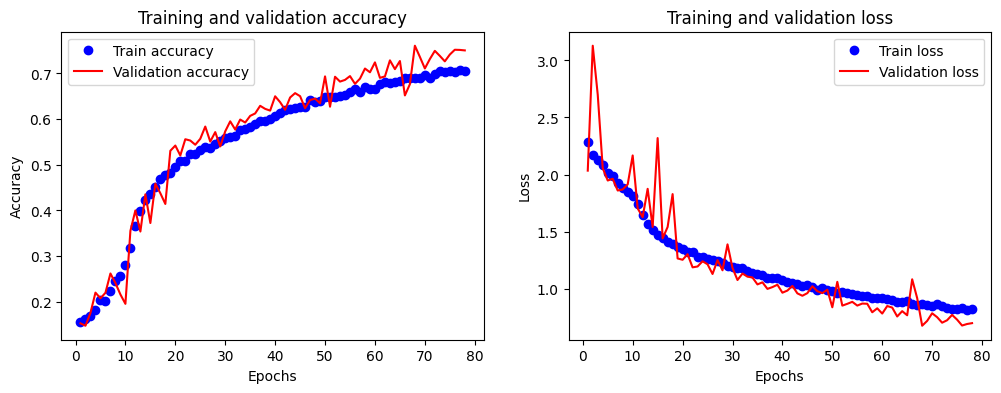

In [25]:
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

ax[0].plot(epochs, train_acc, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train accuracy', 'Validation accuracy'])

ax[1].plot(epochs, train_loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train loss', 'Validation loss'])

plt.show()

#### Configuration Best Model

In [26]:
config_1 = model_1.get_config()

with open('model_config_1.json', 'w') as f:
    json.dump(config_1, f, indent = 4)

In [27]:
with open('model_config_1.json', 'r') as f:
    configoration = json.load(f)

model_conf_1 = keras.Model.from_config(configoration)
model_conf_1.compile(loss="categorical_crossentropy", optimizer= optimizer, metrics=['accuracy'])
model_conf_1.load_weights(f'checkpoints/model_1.weights.h5')

#### Train set Confusion Matrix

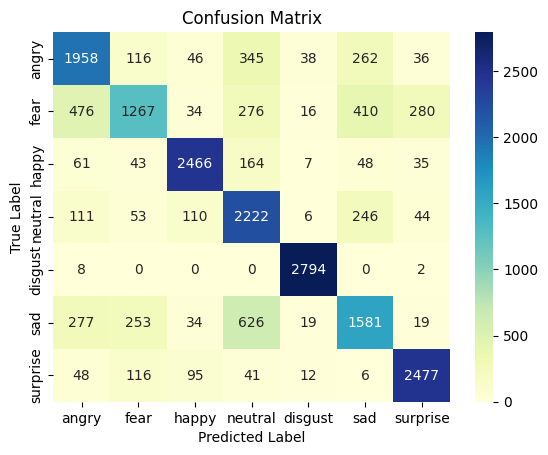

306/306 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7523 - loss: 0.6932
final train accuracy = 75.53 % ,final train loss = 0.6843 
------------------------------------------------------------------------------------------------------
Classification Report for train is:

              precision    recall  f1-score   support

       angry       0.67      0.70      0.68      2801
        fear       0.69      0.46      0.55      2759
       happy       0.89      0.87      0.88      2824
     neutral       0.60      0.80      0.69      2792
     disgust       0.97      1.00      0.98      2804
         sad       0.62      0.56      0.59      2809
    surprise       0.86      0.89      0.87      2795

    accuracy                           0.75     19584
   macro avg       0.75      0.75      0.75     19584
weighted avg       0.76      0.75      0.75     19584



In [28]:
y_true_train = []
y_pred_train = []

for images, labels in train:
    predictions = model_conf_1.predict(images, verbose = 0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    y_true_train.extend(true_classes)
    y_pred_train.extend(predicted_classes)

conf_matrix_train = confusion_matrix(y_true_train, y_pred_train)

class_names_train = []
for name in label_to_index.keys():
    class_names_train.append(name)


sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names_train, yticklabels=class_names_train)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# ----------------------------------------------------------------------

train_loss, train_acc = model_conf_1.evaluate(train)
print("final train accuracy = {:.2f} % ,final train loss = {:.4f} ".format(train_acc*100, train_loss))

print('------------------------------------------------------------------------------------------------------')
report = classification_report(y_true_train, y_pred_train, target_names=class_names_train)
print('Classification Report for train is:\n')
print(report)

#### Test Set Confusion Matrix

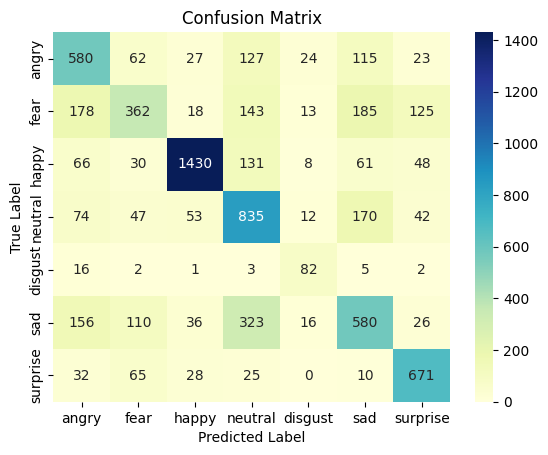

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5947 - loss: 1.1330
final test accuracy = 63.25 % ,final test loss = 1.0445 
------------------------------------------------------------------------------------------------------
Classification Report for train is:

              precision    recall  f1-score   support

       angry       0.53      0.61      0.56       958
        fear       0.53      0.35      0.43      1024
       happy       0.90      0.81      0.85      1774
     neutral       0.53      0.68      0.59      1233
     disgust       0.53      0.74      0.62       111
         sad       0.52      0.47      0.49      1247
    surprise       0.72      0.81      0.76       831

    accuracy                           0.63      7178
   macro avg       0.61      0.64      0.61      7178
weighted avg       0.64      0.63      0.63      7178



In [29]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model_conf_1.predict(images, verbose = 0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

conf_matrix = confusion_matrix(y_true, y_pred)

class_names = []
for name in label_to_index.keys():
    class_names.append(name)


sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ----------------------------------------------------------------------

test_loss_1, test_acc_1 = model_conf_1.evaluate(test_dataset)
print("final test accuracy = {:.2f} % ,final test loss = {:.4f} ".format(test_acc_1*100, test_loss_1))

print('------------------------------------------------------------------------------------------------------')
report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report for train is:\n')
print(report)

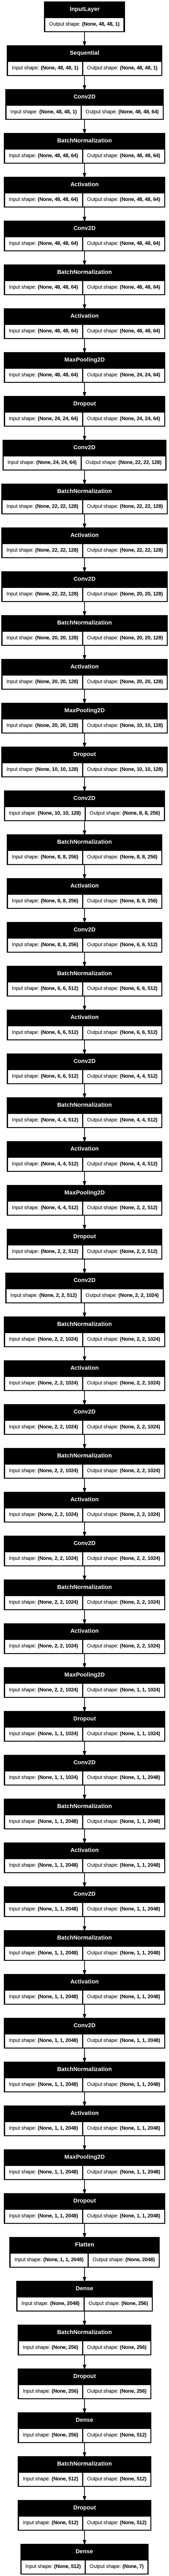

In [30]:
tf.keras.utils.plot_model(model_conf_1, show_shapes=True)